In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
tf.enable_eager_execution()

In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

### CREATING DATA

In [6]:
TRAIN_EXAMPLES = 10000
TRAIN_EXAMPLES_ADV = 1000
TEST_EXAMPLES = 100

train_inputs  = np.random.uniform(size=TRAIN_EXAMPLES, low=0, high=10)
train_inputs_adv  = np.random.uniform(size=TRAIN_EXAMPLES_ADV, low=0, high=10)
test_inputs = np.random.uniform(size=TEST_EXAMPLES, low=0, high=10)

In [7]:
train_data = pd.DataFrame({'Value':train_inputs, 'Label':((np.floor(train_inputs) % 2) == 0).astype('int32')})
train_data_adv = pd.DataFrame({'Value':train_inputs_adv, 'Label':((np.floor(train_inputs_adv) % 2) == 0).astype('int32')})
test_data = pd.DataFrame({'Value':test_inputs, 'Label':((np.floor(test_inputs) % 2) == 0).astype('int32')})

In [36]:
train_data_adv.head()

,Value,Label
0,4.690665,1
1,0.070493,1
2,2.979672,1
3,3.561844,0
4,1.653772,0


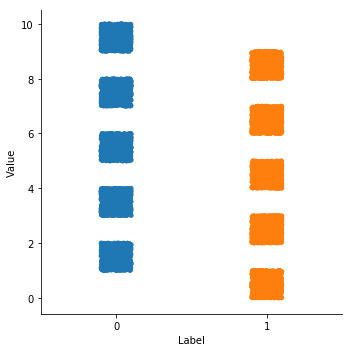

In [7]:
sns.catplot(data=train_data, y='Value', x='Label')

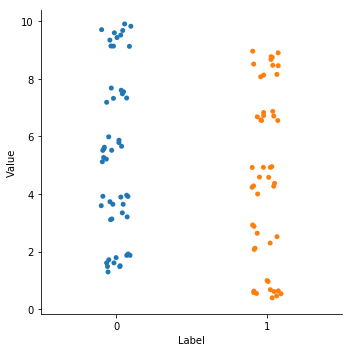

In [8]:
sns.catplot(data=test_data, y='Value', x='Label')

### TRAINING MODEL

##### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [10]:
myTree = DecisionTreeClassifier(random_state=7)
myTree.fit(train_data['Value'].values.reshape(-1,1), train_data['Label'].values.reshape(-1,1))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best')

In [11]:
y_pred = myTree.predict(test_data['Value'].values.reshape(-1,1))
accuracy_score(y_pred, test_data['Label'].values)

1.0

##### Neural Network

In [11]:
classifierModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

classifierModel.compile(optimizer=tf.train.AdamOptimizer(),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
classifierModel.fit(np.reshape(train_data['Value'].values.astype(np.float64), newshape=(-1,1)), 
                    np.reshape(train_data['Label'].values.astype(np.int64), newshape=(-1,1)),
                    epochs=2, batch_size=50, validation_split=0.2)

In [14]:
classifierModel.evaluate(test_data['Value'].values.astype(np.float64), test_data['Label'].values.astype(np.int64))

4/4 [==============================] - 0s 7ms/step


[0.3036344909667969, 0.89]

In [15]:
classifierModel.save_weights('./classifierNNWeights')

### TRAINING NOISE

##### NN with Cross Entropy

In [8]:
REG_COEFF = 1.5
MIS_COEFF = 5.0
BATCH_SIZE = 10
NUM_EPOCHS = 200
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}


adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(np.reshape(train_data_adv['Value'].values, newshape=(-1,1)), tf.float32),
    tf.cast(np.reshape(train_data_adv['Label'].values, newshape=(-1,1)), tf.int64)))

dataset = dataset.batch(BATCH_SIZE)

In [9]:
adversarialModel.summary()

ValueError: This model has never been called, thus its weights have not yet been created, so no summary can be displayed. Build the model first (e.g. by calling it on some data).

In [10]:
optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):

        with tf.GradientTape() as tape:
            
            pred_labels = classifierModel(vals)
            noise = adversarialModel(vals)
            new_labels = classifierModel(tf.add(vals, noise))

            regTerm = tf.math.multiply(tf.reduce_mean(tf.math.abs(noise)), REG_COEFF)
#             missTerm = tf.math.multiply(tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
#                             tf.math.subtract(1, tf.argmax(pred_labels, axis=1)), new_labels)), MIS_COEFF)
            missTerm = tf.math.multiply(myLoss(pred_labels, new_labels), MIS_COEFF)

            loss = tf.add(regTerm, missTerm)

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())

        if batch % 50 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels.numpy())
            modelHistory['new_labels'].append(new_labels.numpy())


NameError: name 'classifierModel' is not defined

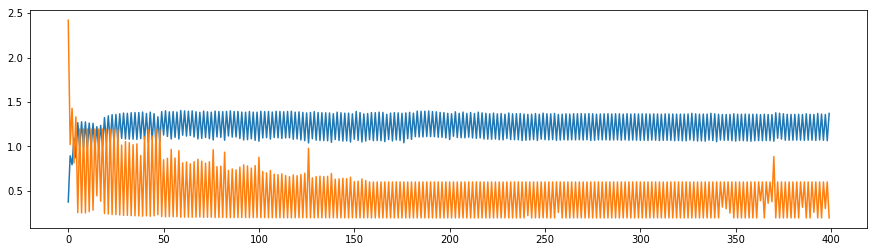

In [224]:
plt.figure(figsize=(15,4))
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])
# plt.savefig('Plot-3.png')

In [225]:
adversarialModel([[2.5], [3.4], [2.2], [7.7]])

<tf.Tensor: id=58072354, shape=(4, 1), dtype=float32, numpy=
array([[-0.99986],
       [-1.00000],
       [-0.99830],
       [-1.00000]], dtype=float32)>

In [26]:
pred_temp = tf.constant([[0.01147, 0.98853],
         [0.00000, 1.00000],
         [0.99151, 0.00849],
         [0.26106, 0.73894],
         [0.50131, 0.49869],
         [0.99630, 0.00370],
         [0.44431, 0.55569],
         [0.42876, 0.57124],
         [0.22989, 0.77011],
         [0.00000, 1.00000]])
new_temp = tf.constant([[0.00954, 0.99046],
         [0.00000, 1.00000],
         [0.99190, 0.00810],
         [0.23041, 0.76959],
         [0.81404, 0.18596],
         [0.99646, 0.00354],
         [0.42733, 0.57267],
         [0.41239, 0.58761],
         [0.21904, 0.78096],
         [0.00000, 1.00000]])
miss_loss = 5.375216

In [27]:
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(tf.math.subtract(1, tf.argmax(pred_temp, axis=1)), new_temp))

<tf.Tensor: id=6223619, shape=(), dtype=float32, numpy=5.375258>

In [196]:
def myLoss(pred, new):
    pred_sparse_inv = tf.math.subtract(1, tf.argmax(pred, axis=1))
#     print("ORIGINAL PRED :", tf.argmax(pred, axis=1))
#     print("INVERTED PRED :", pred_sparse_inv.numpy())
    
    pred_ohe = tf.one_hot(pred_sparse_inv, depth=2, dtype='float32')
#     print("OHE PRED :", pred_ohe)
    
    new_lower = tf.math.multiply(new, pred_ohe)
#     print("NEW LOWER :", new_lower)
    
    final_new = tf.nn.relu(tf.math.subtract(0.6, tf.reduce_sum(new_lower, axis=1)))
#     print("SUMMED LOWER :", final_new)
    
#     print("FINAL LOSS :", tf.reduce_mean(new_lower))
    return tf.reduce_mean(final_new)
    

In [84]:
tf.math.multiply([1.0,0],[2.5,3])

<tf.Tensor: id=25648552, shape=(2,), dtype=float32, numpy=array([2.50000, 0.00000], dtype=float32)>

In [157]:
myLoss(pred_temp, new_temp)

<tf.Tensor: id=41011300, shape=(), dtype=float32, numpy=0.65036905>

In [158]:
modelHistory['noise'][-1]

array([[1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000],
       [1.00000]], dtype=float32)

In [159]:
modelHistory['values'][-1]

array([[6.28107],
       [4.63577],
       [3.30958],
       [5.59133],
       [5.80522],
       [5.00840],
       [1.05843],
       [3.80513],
       [4.39730],
       [3.86903]], dtype=float32)

In [160]:
modelHistory['pred_labels'][-1]

array([[0.29222, 0.70778],
       [0.09457, 0.90543],
       [0.97871, 0.02129],
       [0.88215, 0.11785],
       [0.69846, 0.30154],
       [0.18106, 0.81894],
       [0.98794, 0.01206],
       [0.98070, 0.01930],
       [0.09049, 0.90951],
       [0.94085, 0.05915]], dtype=float32)

In [161]:
modelHistory['new_labels'][-1]

array([[0.35022, 0.64978],
       [0.85833, 0.14167],
       [0.09011, 0.90989],
       [0.30771, 0.69229],
       [0.32027, 0.67973],
       [0.39361, 0.60639],
       [0.04696, 0.95304],
       [0.11044, 0.88956],
       [0.92974, 0.07026],
       [0.12120, 0.87880]], dtype=float32)

In [142]:
myLoss(modelHistory['pred_labels'][-1], modelHistory['new_labels'][-1])

SUMMED LOWER : tf.Tensor(
[0.09978 0.00000 0.00000 0.00000 0.00000 0.05639 0.00000 0.00000 0.00000
 0.00000], shape=(10,), dtype=float32)


<tf.Tensor: id=34838894, shape=(), dtype=float32, numpy=0.015616899>

##### NN with MSE

In [181]:
REG_COEFF = 10.0
MIS_COEFF = 1.0
BATCH_SIZE = 10
NUM_EPOCHS = 10
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}


adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(np.reshape(train_data['Value'].values, newshape=(-1,1)), tf.float32),
    tf.cast(np.reshape(train_data['Label'].values, newshape=(-1,1)), tf.int64)))

dataset = dataset.batch(BATCH_SIZE)

In [182]:
optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):
        
        with tf.GradientTape() as tape:
            
            pred_labels = classifierModel(vals)
            noise = adversarialModel(vals)
            new_labels = classifierModel(tf.add(vals, noise))

            regTerm = tf.math.multiply(tf.reduce_mean(tf.math.abs(noise)), REG_COEFF)
            missTerm = tf.math.multiply(tf.reduce_mean(tf.cast(tf.math.abs(
                        tf.math.subtract(tf.argmax(new_labels, axis=1), 
                                         tf.math.subtract(1, tf.argmax(pred_labels, axis=1)))), dtype=tf.float32)), MIS_COEFF)

            loss = tf.add(0.0, missTerm)

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())
        
        if batch%10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels.numpy())
            modelHistory['new_labels'].append(new_labels.numpy())
    

ValueError: No gradients provided for any variable: ["<tf.Variable 'sequential_27/dense_56/kernel:0' shape=(1, 32) dtype=float32, numpy=\narray([[0.40769, -0.42173, 0.17348, 0.39773, -0.23833, 0.03840, -0.34746,\n        0.34388, 0.34044, 0.23163, -0.16805, 0.10308, -0.01149, 0.02108,\n        0.36514, -0.10401, 0.31591, -0.05579, -0.38195, 0.28266, 0.14739,\n        -0.33268, 0.07754, 0.14226, 0.16608, 0.15056, -0.31268, 0.31612,\n        -0.00803, 0.00937, 0.39809, -0.42474]], dtype=float32)>", "<tf.Variable 'sequential_27/dense_56/bias:0' shape=(32,) dtype=float32, numpy=\narray([0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000], dtype=float32)>", "<tf.Variable 'sequential_27/dense_57/kernel:0' shape=(32, 1) dtype=float32, numpy=\narray([[-0.29608],\n       [0.12203],\n       [-0.08916],\n       [0.06394],\n       [0.37802],\n       [-0.26736],\n       [-0.01670],\n       [0.03174],\n       [-0.27751],\n       [-0.33127],\n       [-0.11258],\n       [-0.23834],\n       [-0.40621],\n       [0.12249],\n       [-0.34884],\n       [0.02532],\n       [-0.20805],\n       [-0.22921],\n       [-0.37431],\n       [-0.39454],\n       [0.10150],\n       [0.15959],\n       [0.32745],\n       [-0.39941],\n       [-0.31263],\n       [-0.40050],\n       [0.05922],\n       [-0.26880],\n       [-0.21995],\n       [0.41699],\n       [0.27475],\n       [-0.31295]], dtype=float32)>", "<tf.Variable 'sequential_27/dense_57/bias:0' shape=(1,) dtype=float32, numpy=array([0.00000], dtype=float32)>"].

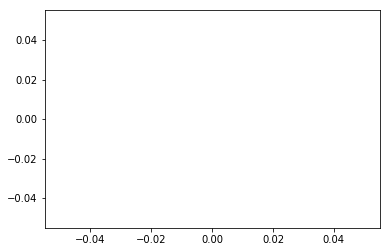

In [183]:
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])

In [162]:
tf.argmax(modelHistory['pred_labels'][-1], axis=1)

<tf.Tensor: id=42075962, shape=(10,), dtype=int64, numpy=array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)>

In [163]:
tf.argmax(modelHistory['new_labels'][-1], axis=1)

<tf.Tensor: id=42075966, shape=(10,), dtype=int64, numpy=array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int64)>

In [180]:
modelHistory['noise'][-1]

array([[0.00024],
       [0.00045],
       [0.00072],
       [0.00084],
       [0.00063],
       [0.00181],
       [-0.00011],
       [0.00038],
       [0.00085],
       [0.00047]], dtype=float32)

In [165]:
modelHistory['values'][-1]

array([[4.44658],
       [4.97225],
       [5.97969],
       [6.46982],
       [5.59160],
       [9.38508],
       [1.18535],
       [4.77804],
       [6.52005],
       [5.05724]], dtype=float32)

In [166]:
modelHistory['pred_labels'][-1]

array([[0.07628, 0.92372],
       [0.71141, 0.28859],
       [0.25155, 0.74845],
       [0.24900, 0.75100],
       [0.89552, 0.10448],
       [0.58070, 0.41930],
       [0.99686, 0.00314],
       [0.10741, 0.89259],
       [0.26053, 0.73947],
       [0.91246, 0.08754]], dtype=float32)

In [167]:
modelHistory['new_labels'][-1]

array([[0.95502, 0.04498],
       [0.58634, 0.41366],
       [0.28208, 0.71792],
       [0.36203, 0.63797],
       [0.22677, 0.77323],
       [0.54220, 0.45780],
       [0.00997, 0.99003],
       [0.84883, 0.15117],
       [0.36634, 0.63366],
       [0.40068, 0.59932]], dtype=float32)

##### Decision Tree with MSE

In [33]:
REG_COEFF = 1.0
MIS_COEFF = 5.0
BATCH_SIZE = 10
NUM_EPOCHS = 1
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}


adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(np.reshape(train_data['Value'].values, newshape=(-1,1)), tf.float32),
    tf.cast(np.reshape(train_data['Label'].values, newshape=(-1,1)), tf.int64)))

dataset = dataset.batch(BATCH_SIZE)

In [34]:
optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):
        
        with tf.GradientTape() as tape:
            
            pred_labels = myTree.predict(vals.numpy())
            noise = adversarialModel(vals)
            new_labels = myTree.predict(tf.add(vals, noise).numpy())

            regTerm = tf.reduce_mean(tf.math.square(noise))
            missTerm = tf.reduce_mean(tf.cast(tf.math.abs(
                        tf.math.subtract(new_labels, tf.math.subtract(1, pred_labels))), dtype=tf.float32))

            loss = missTerm
            #tf.add(tf.math.multiply(0.0, REG_COEFF), tf.math.multiply(missTerm, MIS_COEFF))

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())
        
        if batch%10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels)
            modelHistory['new_labels'].append(new_labels)
    

ValueError: No gradients provided for any variable: ["<tf.Variable 'sequential_3/dense_6/kernel:0' shape=(1, 32) dtype=float32, numpy=\narray([[ 2.88196266e-01,  3.85440886e-01,  4.61042225e-02,\n         3.13634157e-01, -2.14485824e-01,  2.37595558e-01,\n         3.65222454e-01,  2.92484403e-01,  4.05001998e-01,\n         2.87741423e-01,  4.15382981e-01,  1.40994787e-04,\n        -5.53731620e-02,  4.25974369e-01,  2.95409918e-01,\n        -4.09557372e-01, -2.68551618e-01, -6.13611937e-03,\n        -4.68383431e-02,  1.44419253e-01, -3.01740319e-01,\n        -2.23388776e-01, -3.33287954e-01,  2.30480134e-01,\n         3.58040512e-01,  2.95596182e-01,  1.00669205e-01,\n         2.77746022e-01,  1.24676466e-01,  3.33411694e-01,\n        -1.15648687e-01,  1.37585700e-01]], dtype=float32)>", "<tf.Variable 'sequential_3/dense_6/bias:0' shape=(32,) dtype=float32, numpy=\narray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],\n      dtype=float32)>", "<tf.Variable 'sequential_3/dense_7/kernel:0' shape=(32, 1) dtype=float32, numpy=\narray([[-0.25014216],\n       [-0.02677321],\n       [-0.16590044],\n       [ 0.01334751],\n       [ 0.11586785],\n       [ 0.21186316],\n       [ 0.29636788],\n       [ 0.0011687 ],\n       [ 0.15724003],\n       [-0.41779187],\n       [-0.03569192],\n       [-0.37300092],\n       [-0.09307066],\n       [ 0.0190351 ],\n       [-0.17378554],\n       [ 0.15034372],\n       [-0.1028659 ],\n       [-0.29841077],\n       [-0.23481406],\n       [-0.3392158 ],\n       [ 0.13119495],\n       [ 0.36371744],\n       [ 0.3285126 ],\n       [-0.18267354],\n       [-0.37584704],\n       [-0.40394533],\n       [ 0.03710786],\n       [-0.2671455 ],\n       [ 0.07168719],\n       [ 0.29223043],\n       [ 0.39716595],\n       [ 0.2776329 ]], dtype=float32)>", "<tf.Variable 'sequential_3/dense_7/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>"].

In [ ]:
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])

##### Graphs and Sessions

In [16]:
BATCH_SIZE = 10


def lossFunc(noise, orig_label, value_input):
    
    new_labels = classifierModel.predict(tf.add(noise, value_input), steps=1)
    
    regTerm = tf.reduce_mean(tf.math.square(noise))
    # Comparing accuracy of produced
    missTerm = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(tf.math.subtract(1, orig_label), 
                                                                              new_labels))
    
    # tf.reduce_mean(tf.math.squared_difference(tf.cast(tf.math.subtract(1, orig_label), dtype=tf.int32), 
    #                                                   tf.cast(tf.argmax(newLabel, axis=1), dtype=tf.int32)))
    
    return (tf.math.multiply(regTerm, REG_COEFF), tf.math.multiply(missTerm, MIS_COEFF), new_labels)


def noiseModel(inputs):
    l1 = tf.contrib.layers.flatten(inputs)
    l2 = tf.contrib.layers.fully_connected(l1, 32, activation_fn = tf.nn.tanh)
    l3 = tf.contrib.layers.dropout(l2, keep_prob=0.5)
    l4 = tf.contrib.layers.fully_connected(l3, 1, activation_fn = tf.nn.tanh)
    return l4

value_input = tf.placeholder(tf.float32, shape = (BATCH_SIZE, 1))
orig_label = tf.placeholder(tf.int32, shape = (BATCH_SIZE, 1))

noise = noiseModel(value_input)

regTerm, missTerm, new_labels = lossFunc(noise, orig_label, value_input)
loss = missTerm
# tf.math.add(regTerm, missTerm)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

accuracy = tf.reduce_mean(tf.metrics.accuracy(tf.math.subtract(1, orig_label), tf.argmax(new_labels, axis=1)))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [10,1]
	 [[{{node Placeholder}} = Placeholder[dtype=DT_FLOAT, shape=[10,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node Softmax/_139}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_89_Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
modelHistory = {'regLoss':[], 'missLoss':[], 'totalLoss':[], 'noise':[], 'batchValues':[], 'batchLabels':[], 'newLabels':[]}

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    classifierModel.load_weights('./classifierNNWeights')
    # Training noise on batches of train_data
    
    for epochNum in range(1000):
        
        trainValuesBatches = np.array_split(train_data['Value'].values, int(TRAIN_EXAMPLES/BATCH_SIZE))
        trainLabelsBatches = np.array_split(train_data['Label'].values, int(TRAIN_EXAMPLES/BATCH_SIZE))
        
        for batchNum in np.random.randint(high=int(TRAIN_EXAMPLES/BATCH_SIZE)-1, low=0, size=(BATCH_SIZE, )):
            
            singleBatchValues = np.reshape(trainValuesBatches[batchNum], newshape=(-1,1))
            singleBatchLabels = np.reshape(trainLabelsBatches[batchNum], newshape=(-1,1))
            
            #noise_val = sess.run([noise], feed_dict={value_input : singleBatchValues})
            
            #new_labels_val = classifierModel.predict(trainValuesBatches[batchNum] + np.reshape(noise_val, newshape=(10, )))
            
            # if epochNum == 999:
#             print("ORIG VALUES : ")
#             print(trainValuesBatches[batchNum])
#             print("ORIG LABELS : ")
#             print(classifierModel.predict(trainValuesBatches[batchNum]))
#             print("NOISE : ")
#             print(noise_val)
#             print("NEW LABELS : ")
#             print(new_labels_val)
            
            _, reg_val, miss_val, noise_val, new_labels_val = sess.run([optimizer, regTerm, missTerm, noise, new_labels], 
                                                             feed_dict={value_input : singleBatchValues,
                                                                        orig_label : singleBatchLabels})
            
    
    
    # Testing noise on batches of test_data
    
#     testValuesBatches = np.array_split(test_data['Value'].values, int(TEST_EXAMPLES/BATCH_SIZE))
#     testLabelsBatches = np.array_split(test_data['Label'].values, int(TEST_EXAMPLES/BATCH_SIZE))
    
#     accuHistory = []
    
#     for batchNum in range(int(TEST_EXAMPLES/BATCH_SIZE)):
        
#         acc_val = sess.run([accuracy], feed_dict={value_input : np.reshape(testValuesBatches[batchNum], newshape=(-1,1)),
#                                                    orig_label : np.reshape(testLabelsBatches[batchNum], newshape=(-1,1))})
        
#         accuHistory.append(acc_val)
        

In [ ]:
plt.plot(modelHistory['regLoss'])
plt.plot(modelHistory['missLoss'])
# plt.plot(modelHistory['totalLoss'])

In [ ]:
modelHistory['batchValues'][-1]

In [ ]:
classifierModel.predict(modelHistory['batchValues'][-1])

In [ ]:
modelHistory['noise'][-1][0].reshape(10,)

In [ ]:
modelHistory['batchValues'][-1] + modelHistory['noise'][-1][0].reshape(10,)

In [ ]:
np.argmax(modelHistory['newLabels'][-1], axis=1)

In [ ]:
np.argmax(classifierModel.predict(modelHistory['batchValues'][-1] + modelHistory['noise'][-1][0].reshape(10,)), axis=1)